In [1]:
from qaoa_and_tdvp import QAOA, QAOAResult
from MaxCut import MaxCut
import numpy as np
import pandas as pd
import pickle
import networkx as nx
from itertools import permutations, combinations_with_replacement, product
import swifter
import plotly.express as px
import plotly.graph_objects as go
from scipy.interpolate import griddata



In [2]:
with open('./results/data.p','rb')as f:
    data = pickle.load(f)

# Search instance with maximal difference in path length

In [3]:
scipy_vs_tdvp = data.xs(1,level='p',drop_level=False).apply(
    lambda row: abs(row['scipy']['path length']-row['tdvp']['path length']),
    axis=1,
    )
gd_vs_tdvp = data.xs(1,level='p',drop_level=False).apply(
    lambda row: abs(row['tdvp']['path length']-row['gradient_descent']['path length']),
    axis=1
    )


In [4]:
idx_1= max(gd_vs_tdvp.index, key=lambda idx: gd_vs_tdvp.loc[idx])
idx_1

(5, 1, 5)

In [5]:
idx_2= max(scipy_vs_tdvp.index, key=lambda idx: scipy_vs_tdvp.loc[idx])
idx_2

(3, 1, 0)

In [6]:
scipy_vs_tdvp.loc[idx_1]

6.545014586980474

In [7]:
scipy_vs_tdvp.loc[idx_2]

8.462882718162321

In [8]:
gd_vs_tdvp.loc[idx_1]

0.8717674310106336

In [9]:
gd_vs_tdvp.loc[idx_2]

0.03931027266919984

In [10]:
scipy_vs_tdvp.loc[idx_1] + gd_vs_tdvp.loc[idx_1]

7.416782017991108

In [11]:
scipy_vs_tdvp.loc[idx_2] + gd_vs_tdvp.loc[idx_2]

8.50219299083152

The instance n=5, p=1, i=5 ist most suitable, as it has almost the same combined difference as (3,1,0)

In [42]:
idx = (n,p,i) = (5,1,5)

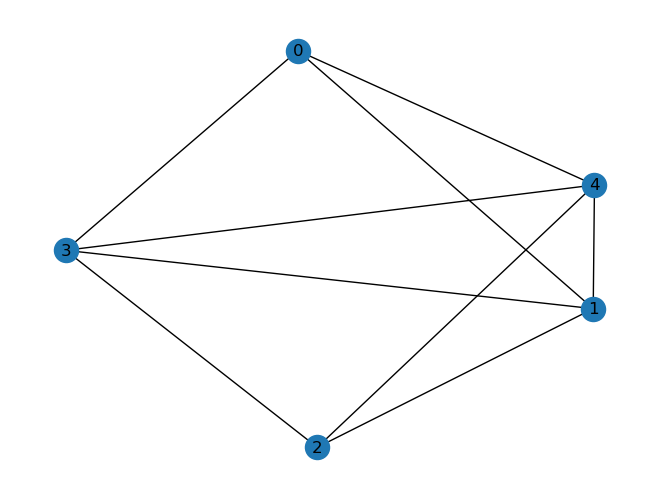

In [43]:
inst = data.loc[idx]['instance']
qaoa = QAOA(inst, p=p)
nx.draw(inst.graph, with_labels=True)

# Determine necessary grid size

In [44]:
path_tdvp = data.loc[idx]['tdvp']['path']
path_scipy = data.loc[idx]['scipy']['path']
path_gd = data.loc[idx]['gradient_descent']['path']
min_beta = min(path_scipy+path_gd+path_tdvp, key=lambda x:x[0])[0]
min_gamma = min(path_scipy+path_gd+path_tdvp, key=lambda x:x[1])[1]
max_beta = max(path_scipy+path_gd+path_tdvp, key=lambda x:x[0])[0]
max_gamma = max(path_scipy+path_gd+path_tdvp, key=lambda x:x[1])[1]

In [45]:
print(min_beta )
print(min_gamma)
print(max_beta )
print(max_gamma)

0.15465210312893096
0.4657838141204813
2.0
2.0


# Do the grid search

In [46]:
d1 = np.linspace(min_beta-.2, max_beta+.2, 100)
d2 = np.linspace(min_gamma-.2, max_gamma+.2, 100)
grid = list(product(d1,d2))

df = pd.DataFrame(data=grid, columns=['beta','gamma'])
df.insert(0,'delta', grid)
df["value"] = df.apply(lambda x: qaoa.expectation(x['delta']), axis=1)
df

,delta,beta,gamma,value
0,"(-0.04534789687106905, 0.2657838141204813)",-0.045348,0.265784,1.415816
1,"(-0.04534789687106905, 0.28532135135158754)",-0.045348,0.285321,1.297098
2,"(-0.04534789687106905, 0.3048588885826938)",-0.045348,0.304859,1.152343
3,"(-0.04534789687106905, 0.3243964258138)",-0.045348,0.324396,0.985544
4,"(-0.04534789687106905, 0.3439339630449063)",-0.045348,0.343934,0.801165
...,...,...,...,...
9995,"(2.2, 2.121849851075575)",2.200000,2.121850,-0.410278
9996,"(2.2, 2.141387388306681)",2.200000,2.141387,-0.354525
9997,"(2.2, 2.1609249255377874)",2.200000,2.160925,-0.289562
9998,"(2.2, 2.1804624627688938)",2.200000,2.180462,-0.214485


In [47]:
# with open('./results/grid_search_n5_p1_i5.p','wb') as f:
#     pickle.dump(df,f)

In [48]:
BA_template = dict(
    layout=go.Layout(
    template='plotly_white',
    yaxis=dict(
        linewidth = 1,
        linecolor = 'black',
        gridcolor = 'lightgrey',
        zerolinecolor = 'black',

    ),
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 1,
        dtick = 1,        
        range=[-.5,5],
        autorange=True,
        # type='category',
        linewidth = 1,
        linecolor = 'black',
        gridcolor = 'lightgrey',
        # zerolinecolor = 'black',

    ),
    font=dict(
        family='Computer Modern',
        size=12,
    ),
    
        
    
    # paper_bgcolor='rgba(0,0,0,0)',   # transparent background
    plot_bgcolor='rgba(0,0,0,0)',)
)

In [49]:
# with open("./results/grid_search_n5_p2_i5.p",'rb') as file:
#     grid_search = pickle.load(file)
grid_search = df
    
with open("results/data.p",'rb') as file:
    data = pickle.load(file)
    


In [57]:
# idx = (5,1,5)
qaoa = QAOA(data.loc[idx]['instance'],p=idx[1])
hover = .5


In [62]:

def get_sizes(zlist):
    size_step = round(len(zlist)/10)
    sizes = [11,]
    for i in range(10*size_step):
        if i%size_step == 0:
            sizes.append(sizes[-1]-1)
        else:
            sizes.append(sizes[-1])
            
    over = len(sizes)-len(zlist)
    for _ in range(over):
        sizes.pop()
    under = len(zlist)-len(sizes)
    for _ in range(under):
        sizes.append(sizes[-1])
    return sizes

init_path = [(1,1)]
init_x = np.array([1,])
init_y = np.array([1,])
init_z = np.array([qaoa.expectation((1,1)),])
tdvp_path = data.loc[idx]['tdvp']['path']
tdvp_x = np.array([d[0] for d in tdvp_path])
tdvp_y = np.array([d[1] for d in tdvp_path])
tdvp_z = np.array([qaoa.expectation(d) for d in tdvp_path])
data.loc[idx]['gradient_descent']['path'].insert(0,(1,1))

gd_path = data.loc[idx]['gradient_descent']['path']
gd_path.insert(0,(1,1))
gd_x = np.array([d[0] for d in gd_path])
gd_y = np.array([d[1] for d in gd_path])
gd_z = np.array([qaoa.expectation(d) for d in gd_path])
# df = grid_search

cobyla_path = data.loc[idx]['scipy']['path']
cobyla_path.insert(0,(1,1))
cobyla_x = np.array([d[0] for d in cobyla_path])
cobyla_y = np.array([d[1] for d in cobyla_path])
cobyla_z = np.array([qaoa.expectation(d) for d in cobyla_path])


x = np.array(df.beta)
y = np.array(df.gamma)
z = np.array(df.value)


xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)

X, Y = np.meshgrid(xi, yi)

Zlandscape = griddata((x, y), z, (X, Y), method="cubic")


Zpath_tdvp = griddata((tdvp_x, tdvp_y), tdvp_z, (xi, yi))

fig = go.Figure(
        go.Surface(
            contours = {
                            "z": {"show": True, "start": -4.18, "end": 0, "size": 1}
                        },
            x=xi, 
            y=yi, 
            z=Zlandscape,
            opacity = 1,
            ),
        )

fig.add_scatter3d(
    x=tdvp_x,
    y=tdvp_y,
    z=tdvp_z+hover,
    name='TDVP',
    marker = dict(
        size=get_sizes(tdvp_z),
        sizemin = 5,
        symbol='diamond', # ( "circle" | "circle-open" | "cross" | "diamond" | "diamond-open" | "square" | "square-open" | "x" ) 
    ),
)
fig.add_scatter3d(
    x=gd_x,
    y=gd_y,
    z=gd_z+hover,
    name='GD',
    line = dict(
        width=4
    ),
    marker=dict(
        size=get_sizes(gd_z),
        sizemin = 5,
        # color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        # opacity=0.8,
        symbol='circle', # ( "circle" | "circle-open" | "cross" | "diamond" | "diamond-open" | "square" | "square-open" | "x" ) 
        
    )
)
# fig.add_scatter3d(
#     x=cobyla_x,
#     y=cobyla_y,
#     z=cobyla_z+hover,
#     name='COBYLA',
#     line = dict(
#         width=4
#     ),
#     marker=dict(
#         size=get_sizes(cobyla_z),
#         sizemin = 5,
#         # color=z,                # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         # opacity=0.8,
#         symbol='circle-open', # ( "circle" | "circle-open" | "cross" | "diamond" | "diamond-open" | "square" | "square-open" | "x" ) 
        
#     )
# )
fig.add_scatter3d(
    x=init_x,
    y=init_y,
    z=init_z+hover,
    name='Initial point = (1,1)',
    line = dict(
        width=4
    ),
    marker=dict(
        size=5,
        color= 'red',
        symbol='x',
        opacity = .7,
    )
)

# fig.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))

fig.update_traces(showscale=False, selector=dict(type='surface'))

fig.update_layout(
    template=BA_template, 
    width=1000, 
    height=1000,
    legend = dict(
        yanchor="top",
        xanchor="left",
        y = 0.9,
        x = 0.1,
    ),
    scene = dict(
        xaxis_title=u'\u03B2',
        yaxis_title=u'\u03B3',
        zaxis_title=u'\u27E8H\u27E9',
        xaxis= {"nticks": 20},
        zaxis ={"nticks": 10},
        camera_eye ={"x": -1.4, "y": 1, "z": 1.4},
        aspectratio ={"x": 1, "y": 1, "z": .6}
        )
    )
# fig.show()
fig.write_image('./plots/grid_seach_n5_p1_i5.pdf')
